In [6]:
import pickle
from PIL import Image
import numpy as np
from tqdm import tqdm

target_size = 256

In [7]:
## 피클파일 없을 때 실행

# 메타데이터 및 텍스트 데이터 로드

train_path = './train_data/%s'
metadata = pickle.load(open('./data/sentence_gamjung2.pkl', 'rb'))

# clean_text에 시작, 끝 추가
# clean_text 기준 256글자 넘지 않도록 필터링
# 각 감정 클래스가 최대한 균등하도록 샘플 추출
# 학습 5000, 검증 1000, 테스트 1000

metadata['clean_text'] = metadata['clean_text'].apply(lambda x: '\t%s\n' %x.strip())
metadata = metadata[metadata['clean_text'].str.len() <= 256]

sentiment_list = ['emotion_0', 'emotion_1', 'emotion_3', 'emotion_4']
sentiment_indices = [metadata[metadata[senti] == 1].index for senti in sentiment_list]
data_indices = []

i = 0
condition = True
while condition:
    for senti in sentiment_indices:
        if len(set(data_indices)) < 7000:
            data_indices.append(senti[i])
        else:
            condition = False
            break
    i += 1
    
metadata = metadata.iloc[sorted(list(set(data_indices)))]

def get_image_from_path(path):
    image = Image.open(train_path %path)
    size = image.size

    if size[0] <= size[1]:
        scaled_size = (target_size, int(size[1]/size[0]*target_size))
        crop_area = (0, int((scaled_size[1]-target_size)/2), target_size, int((scaled_size[1]+target_size)/2))
    else:
        scaled_size = (int(size[0]/size[1]*target_size), target_size)
        crop_area = (int((scaled_size[0]-target_size)/2), 0, int((scaled_size[0]+target_size)/2), target_size)

    image = image.resize(scaled_size)
    image = image.crop(crop_area)
    return image

def get_array_from_path(path):
    return np.asarray(get_image_from_path(path))

# 이미지 불러와서 데이터셋 생성
image_data = np.array([image for image in metadata['image_path'].map(get_array_from_path)])
sentiment_data = np.array(metadata[sentiment_list])
sentence_data = np.array(metadata['clean_text'])

# 데이터 피클로 저장
pickle.dump([image_data, sentiment_data, sentence_data], open('data.pkl', 'wb'))

In [7]:
# 피클로 저장된 데이터 로드
image_data, sentiment_data, sentence_data = pickle.load(open('data.pkl', 'rb'))

In [8]:
print(image_data.shape)
print(sentiment_data.shape)
print(sentence_data.shape)

(7000, 256, 256, 3)
(7000, 4)
(7000,)


In [9]:
# RNN 준비과정

output_chars = set()
for s in sentence_data:
    for c in s:
        if c not in output_chars:
            output_chars.add(c)
            
output_chars = sorted(list(output_chars))
num_decoder_tokens = len(output_chars)
max_decoder_seq_length = 256

output_token_index = {c: i for i, c in enumerate(output_chars)}
reverse_output_char_index = dict((i, c) for c, i in output_token_index.items())

decoder_input_data = np.zeros(shape=(7000, max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_output_data = np.zeros(shape=(7000, max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, s in enumerate(sentence_data):
    for j, c in enumerate(s):
        decoder_input_data[i, j, output_token_index[c]] = 1.
        if j > 0:
            decoder_output_data[i, j-1, output_token_index[c]] = 1.

In [10]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.reset_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


In [11]:
# 이미지 (CNN)

X = tf.placeholder(tf.float32, shape=[None, target_size, target_size, 3])

n_conv_1 = 64
k_conv_1 = 5
W_conv_1 = tf.Variable(tf.truncated_normal(shape=[k_conv_1,k_conv_1,3,n_conv_1], stddev=5e-2))
b_conv_1 = tf.Variable(tf.constant(0.1, shape=[n_conv_1]))
h_conv_1 = tf.nn.relu(tf.nn.conv2d(X, W_conv_1, strides=[1,1,1,1], padding='SAME') + b_conv_1)
h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

n_conv_2 = 64
k_conv_2 = 5
W_conv_2 = tf.Variable(tf.truncated_normal(shape=[k_conv_2,k_conv_2,n_conv_1,n_conv_2], stddev=5e-2))
b_conv_2 = tf.Variable(tf.constant(0.1, shape=[n_conv_2]))
h_conv_2 = tf.nn.relu(tf.nn.conv2d(h_pool_1, W_conv_2, strides=[1,1,1,1], padding='SAME') + b_conv_2)
h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

n_conv_3 = 128
k_conv_3 = 3
W_conv_3 = tf.Variable(tf.truncated_normal(shape=[k_conv_3,k_conv_3,n_conv_2,n_conv_3], stddev=5e-2))
b_conv_3 = tf.Variable(tf.constant(0.1, shape=[n_conv_3]))
h_conv_3 = tf.nn.relu(tf.nn.conv2d(h_pool_2, W_conv_3, strides=[1,1,1,1], padding='SAME') + b_conv_3)
h_pool_3 = tf.nn.max_pool(h_conv_3, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

n_conv_4 = 128
k_conv_4 = 3
W_conv_4 = tf.Variable(tf.truncated_normal(shape=[k_conv_4,k_conv_4,n_conv_3,n_conv_4], stddev=5e-2))
b_conv_4 = tf.Variable(tf.constant(0.1, shape=[n_conv_4]))
h_conv_4 = tf.nn.relu(tf.nn.conv2d(h_pool_3, W_conv_4, strides=[1,1,1,1], padding='SAME') + b_conv_4)

n_conv_5 = 128
k_conv_5 = 3
W_conv_5 = tf.Variable(tf.truncated_normal(shape=[k_conv_5,k_conv_5,n_conv_4,n_conv_5], stddev=5e-2))
b_conv_5 = tf.Variable(tf.constant(0.1, shape=[n_conv_5]))
h_conv_5 = tf.nn.relu(tf.nn.conv2d(h_conv_4, W_conv_5, strides=[1,1,1,1], padding='SAME') + b_conv_5)
h_conv_5_flat = tf.reshape(h_conv_5, [-1, h_conv_5.shape[1]*h_conv_5.shape[2]*h_conv_5.shape[3]])

n_fc_1 = 256
k_conv_1 = 5
W_fc_1 = tf.Variable(tf.truncated_normal(shape=[h_conv_5_flat.shape[1], n_fc_1], stddev=5e-2))
b_fc_1 = tf.Variable(tf.constant(0.1, shape=[n_fc_1]))
h_fc_1 = tf.nn.relu(tf.matmul(h_conv_5_flat, W_fc_1) + b_fc_1)

h_fc_1_drop = tf.nn.dropout(h_fc_1, 0.8)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# 감정

n_senti = 4

S = tf.placeholder(tf.float32, shape=[None, n_senti])

h_pre_s = tf.tile(h_fc_1_drop, [1, n_senti]) * tf.repeat(S, n_fc_1, axis=1)

n_final = 512
W_final = tf.Variable(tf.truncated_normal(shape=[n_senti*n_fc_1, n_final]))
b_final = tf.Variable(tf.constant(0.1, shape=[n_final]))
h_final = tf.matmul(h_pre_s, W_final) + b_final

In [15]:
# 문장 생성 (RNN)

learning_rate = 1e-2
n_hidden = 25
n_class = n_input = num_decoder_tokens

enc_input = tf.reshape(h_final, [-1, n_final, 1])
dec_output = tf.placeholder(tf.int64, [None, max_decoder_seq_length])

dec_cell = tf.nn.rnn_cell.LSTMCell(n_hidden)
outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, enc_input, dtype=tf.float32,
                                       scope='decoder')

model = tf.layers.dense(outputs, n_class, activation=None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=dec_output))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [16]:
outputs, model

(<tf.Tensor 'decoder/transpose_1:0' shape=(?, 512, 25) dtype=float32>,
 <tf.Tensor 'dense/BiasAdd:0' shape=(?, 512, 1699) dtype=float32>)

In [17]:
with tf.device('/gpu:0'):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                            log_device_placement=True))
    sess.run(tf.global_variables_initializer())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5



In [24]:
total_epoch = 50
total_size = 5000
section_size = 1000
batch_size = 100
n_section = total_size // section_size
n_batch = section_size // batch_size

valid_image = image_data[total_size:total_size+section_size]
valid_sentiments = sentiment_data[total_size:total_size+section_size]
valid_input_data = np.zeros(shape=(section_size, max_decoder_seq_length, len(output_chars)), dtype='float32')
valid_output_data = np.zeros(shape=(section_size, max_decoder_seq_length))

for i, s in enumerate(sentence_data[total_size:total_size+section_size]):
    for j, c in enumerate(s):
        valid_input_data[i, j, output_token_index[c]] = 1.
        if j > 0:
            valid_output_data[i, j-1] = output_token_index[c]

for epoch in range(total_epoch):
    total_loss = 0
    for section in tqdm(range(n_section)):
        dec_input_data = np.zeros(shape=(section_size, max_decoder_seq_length, len(output_chars)), dtype='float32')
        #dec_output_data = np.zeros(shape=(1000, max_seq_length, len(output_chars)), dtype='float32')
        dec_output_data = np.zeros(shape=(section_size, max_decoder_seq_length))

        for i, s in enumerate(sentence_data[section*section_size:(section+1)*section_size]):
            for j, c in enumerate(s):
                dec_input_data[i, j, output_token_index[c]] = 1.
                if j > 0:
                    dec_output_data[i, j-1] = output_token_index[c]

        for batch in range(n_batch):
            # print('sect: %03d batch: %03d' %(section, batch))
            batch_images = image_data[n_batch*batch:n_batch*(batch+1)]
            batch_sentiments = sentiment_data[n_batch*batch:n_batch*(batch+1)]
            batch_dec_outputs = dec_output_data[n_batch*batch:n_batch*(batch+1)]

            _, loss = sess.run([optimizer, cost], feed_dict={
                X: batch_images,
                S: batch_sentiments,
                dec_output: batch_dec_outputs
            })

            total_loss += loss
        
    total_valid_loss = 0
    for batch in range(10):
        valid_inp = [0] + [2]*(max_seq_length-1)
        valid_inp = np.array([np.eye(dict_len)[valid_inp]] * n_batch)
        valid_loss = sess.run(cost, feed_dict={
            X: valid_image[n_batch*batch:n_batch*(batch+1)],
            S: valid_sentiments[n_batch*batch:n_batch*(batch+1)],
            dec_output: valid_output_data[n_batch*batch:n_batch*(batch+1)]
        })
        total_valid_loss += valid_loss
        

    print('Epoch: %04d Cost: %.6f Valid Cost: %.6f' %(epoch + 1, total_loss / n_section / n_batch, valid_loss))

  0%|          | 0/5 [00:01<?, ?it/s]


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: assertion failed: [Condition x == y did not hold element-wise:] [x (SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [10 256] [y (SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [10 512]
	 [[node SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-15-4c1115c8db73>:15) ]]
	 [[Mean/_45]]
  (1) Invalid argument: assertion failed: [Condition x == y did not hold element-wise:] [x (SparseSoftmaxCrossEntropyWithLogits/Shape_1:0) = ] [10 256] [y (SparseSoftmaxCrossEntropyWithLogits/strided_slice:0) = ] [10 512]
	 [[node SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert (defined at <ipython-input-15-4c1115c8db73>:15) ]]
0 successful operations.
0 derived errors ignored.

Original stack trace for 'SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert':
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2923, in _run_cell
    return runner(coro)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3147, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-4c1115c8db73>", line 15, in <module>
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=dec_output))
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py", line 4107, in sparse_softmax_cross_entropy_with_logits
    array_ops.shape(logits)[:-1]))
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/ops/check_ops.py", line 671, in assert_equal
    data, summarize, message, name)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/ops/check_ops.py", line 373, in _binary_assert
    return control_flow_ops.Assert(condition, data, summarize=summarize)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py", line 247, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py", line 167, in Assert
    return gen_logging_ops._assert(condition, data, summarize, name="Assert")
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 63, in _assert
    name=name)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3485, in _create_op_internal
    op_def=op_def)
  File "/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1949, in __init__
    self._traceback = tf_stack.extract_stack()


In [38]:
def translate(image, senti):
    prediction = tf.argmax(model, 2)
    dec_inp = [0] + [2]*(max_seq_length-1)
    dec_inp = [np.eye(dict_len)[dec_inp]]
    dec_out = np.zeros(shape=(1, max_seq_length, ))
    dec_out = [[2]*(max_seq_length-1) + [1]]
    # dec_out = np.eye(dict_len)[dec_out]
    result = sess.run(prediction, 
                      feed_dict={X: image,
                                 S: senti,
                                 dec_input: dec_inp,
                                 dec_output: dec_out})
    decoded = [output_chars[i] for i in result[0]]
    end = decoded.index('\n') if '\n' in decoded else len(decoded)
    translated = ''.join(decoded[:end])
    return translated

In [40]:
for idx in range(10):
    print(sentence_data[idx:idx+1])
    print(translate(image_data[idx:idx+1], sentiment_data[idx:idx+1], sentence_data[idx:idx+1]))

['\t나무 같은 내가 되어 언제나 그대를 지켜줄게요 그대가 힘들 땐 내게 기대 잠시 쉬어갈 수 있도록 여기에서 기다릴게요 나무 양요섭 가사 중에서 천주교광주대교구청 본 사진은 사회적거리두기 단계 격상 전 마스크 착용 및 방역수칙을 준수하며 촬영하였습니다 여행이 있는 우리의 일상을 되찾기 위해 방역수칙을 꼭 준수해주세요\n']
																																																																																																																																																																																																																																																																
['\t나쁜에너지를 내뿜는 사람들을 끊어내라 많은 사람을 곁에 두려 하지 말고 긍정적인 사람들을 곁에 두려 노력하라 좋은사람에게만 좋은사람이면돼에서\n']
																																																																																																																																																																																																																																																																
['\t따뜻한가요\n']
																																																																																																																																																																																																									

In [55]:
idx = 1
image, senti = image_data[idx:idx+1], sentiment_data[idx:idx+1]
prediction = tf.argmax(model, 2)
dec_inp = [0] + [2]*(max_seq_length-1)
dec_inp = [np.eye(dict_len)[dec_inp]]
dec_out = [[0]*(max_seq_length)]
dec_out = np.eye(dict_len)[dec_out]
result = sess.run(prediction, 
                  feed_dict={X: image,
                             S: senti,
                             dec_input: dec_inp,
                             dec_output: dec_out})
decoded = [output_chars[i] for i in result[0]]
end = decoded.index('\n') if '\n' in decoded else len(decoded)
translated = ''.join(decoded[:end])

/home/svclaw2000/venv_capstone/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys


ValueError: Cannot feed value of shape (1, 256, 1699) for Tensor 'Placeholder_3:0', which has shape '(?, 256)'

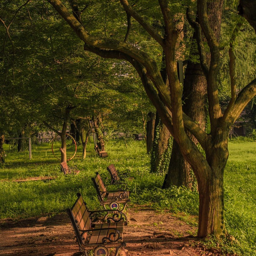

In [5]:
Image.fromarray(image_data[0])

In [35]:
sess.close()